In [28]:
%%capture
# may take a while to build font cache
%matplotlib inline    

In [2]:
import radd
from radd import build, vis

# Formatting data for radd
## Required columns
* **idx**: Subject ID number
* **ttype**: Trial-Type ('go' if no stop-signal, 'stop' if stop-signal trial)
* **response**: Trial Response (1 if response recorded, 0 if no response)
* **acc**: Choice Accuracy (1 if correct, 0 if error)
* **rt**: Choice Response-Time (in seconds, can be any value no-response trials)
* **ssd**: Stop-Signal Delay (in milliseconds, 1000 on go trials)

## Optional columns
* input dataframe can contain columns for experimental conditions of interest (choose any name)
* in the dataframe above, the **Cond** column contains **'bsl'** and **'pnl'**  
    * in the **'bsl'** or **"Baseline"** condition, errors on **go** and **stop** trials are equally penalized 
    * in the  **'pnl'** or **"Caution"** condition, penalties are doubled for **stop** trial errors  (e.g., response=1)
* See below for fitting models with conditional parameter dependencies 
    * e.g., drift-rate depends on levels of 'Cond'

In [29]:
# read data into pandas DataFrame (http://pandas.pydata.org/)
# example_data contains data from 15 subjects in the 
# Reactive Stop-Signal task discussed in Dunovan et al., (2015)
data = radd.load_example_data()
data.head()

,idx,Cond,ttype,choice,response,acc,rt,ssd
0,28,bsl,go,go,1,1,0.59853,1000
1,28,bsl,go,go,1,1,0.52017,1000
2,28,bsl,go,go,1,1,0.54513,1000
3,28,bsl,go,go,1,1,0.57159,1000
4,28,bsl,go,go,1,1,0.50522,1000


# Building a model

In [30]:
# initiate dependent process model 
model = build.Model(kind='xdpm', data=data)

# Animation of Dependent Process Model

In [31]:
# Initial state of Stop process (red) depends on current strength of Go activation (green)
# Assumes Stop signal efficacy at later SSDs diminishes as the state of the Go process 
# approaches the execution threshold (upper bound). pink lines denote t=SSD, blue is trial deadline
radd.load_dpm_animation()

## Header of observed dataframe (model.observedDF)
* **idx**: subject ID
* **Cond**: Baseline(bsl)/Caution(pnl) (could be any experimental condition of interest) 
* **Acc**: Accuracy on "go" trials
* **sacc**: Mean accuracy on "stop" trials (mean condition SSD used during simulations)
* **c10 - c90**: 10th - 90th RT quantiles for correct responses
* **e10 - e90**: 10th - 90th RT quantiles for error responses

In [32]:
model.observedDF.head()

,idx,flat,acc,200,250,300,350,400,c10,c20,...,c90,e10,e20,e30,e40,e50,e60,e70,e80,e90
0,28,flat,0.98347,1.0,1.0,0.95,0.700,0.050,0.50522,0.53171,...,0.61167,0.50518,0.52004,0.53177,0.53559,0.54524,0.55833,0.55854,0.57165,0.58443
1,29,flat,0.97934,1.0,1.0,1.00,0.825,0.175,0.53145,0.54498,...,0.62468,0.53145,0.54422,0.54505,0.54514,0.55842,0.55858,0.57177,0.58495,0.59776
2,30,flat,0.90496,1.0,1.0,1.00,0.725,0.350,0.51852,0.55807,...,0.63841,0.53180,0.54520,0.55846,0.57177,0.57194,0.58530,0.59840,0.60162,0.61176
3,31,flat,0.98347,1.0,1.0,1.00,0.750,0.150,0.53173,0.54495,...,0.61174,0.51605,0.53175,0.54052,0.54512,0.54576,0.55841,0.57138,0.58232,0.59847
4,32,flat,0.95868,1.0,1.0,1.00,0.750,0.100,0.54493,0.55841,...,0.63823,0.51842,0.54509,0.54519,0.55839,0.56475,0.57185,0.58506,0.59781,0.60014


# Bounded Global & Local Optimization

## Stochastic Global Optimization (Basinhopping w/ bounds)

**set_basinparams()** method gives control over low-level parameters used for global opt
* **xtol = ftol = tol**: error tolerance of global optimization (default=1e-20)

* **stepsize** (default=.05): set basinhopping initial step-size
    * see HopStep class in radd.fit for more details
    * see get_stepsize_scalars() in radd.theta for parameter-specific step-sizes

* **nsamples** (default=5000): number of parameter sets to sample
    * optimization is performed on best **ninits** (see below) 

* **ninits** (default=5): number of initial parameter sets to perform global optimization on
    * evaluate all **nsamples** parameter sets, select **ninits** with the lowest error 
    * perform global optimization using each parameter set (out of the **ninits** chosen)
    * pass the optimized parameters with the lowest global minimum to local optimizer 

* **nsuccess** (default=40): criterion number of successful steps without finding new global minimum to exit basinhopping

* **interval** (default=10): number of steps before adaptively updating the stepsize 

* **T** (default=1.0): set the basinhopping "temperature"
    * higher T will result in accepted steps with larger changes in function value (larger changes in model error)

## Local Optimization (Nelder-Mead Simplex w/ bounds)
**set_fitparams()** method gives control over low-level parameters used for local opt. Local optimization polishes parameter estimates passed from global optimization step.

* **xtol = ftol = tol** (default=1e-30): error tolerance of optimization

* **maxfev** (default=2000): max number of func evaluations to perform

* **ntrials** (default=20000): num. simulated trials per condition

* **quantiles** (default=np.array([.10, .20, ... .90]): quantiles of RT distribution to fit

# Setting parameters example
### Set basinparams
```python
model.set_basinparams(tol=1e-25, stepsize=.05, nsamples=2000, ninits=3)
```
### Set fitparams
```python
quantiles=np.arange(.1, 1.,.05)
model.set_fitparams(tol=1e-35, ntrials=30000, maxfev=2500, quantiles=quantiles)
```

# Steps in Fitting Routine


## Step 1. Flat Fits
- All models are initially fit by optimizing the full set of parameters to the "flattened" data (flat meaning the average data collapsing across all conditions of interest). For instance, at this stage fitting the dependent process model involves finding the parameter values for each included parameter that minimizes the cost-function cost function: 

    $$Cost = \sum [\omega * (\hat{Y} - Y)]^2$$
    
  
- **$Y$** is an array of observed data (e.g., accuracy, RT quantiles, etc.) 
- **$\hat{Y}$** is an equal length array of corresponding model-predicted values given parameters $\theta$
- The error between the predicted and the observed data (**$\hat{Y} - Y$**) is weighted by an equal length array of scalars **$\omega$** proportional to the inverse of the variance in each value of **$Y$**. 
- The array of weighted differences is summed, yielding a single cost value equal to the summed squared-error (**$SSE$**). 

| Parameters $(\theta)$ | Description | Go/Stop |
|:--:|:--|:---:|
| $a$  | Boundary Height | -- |
| $tr$  | Onset-Delay | Go |
| $v$ | Drift-Rate | Go | 
| $xb$ | Dynamic Gain | Go |
| $ssv$ | Drift-Rate | Stop |
| $sso$ | Onset-Delay | Stop |

### Step 1a: 
- Global optimzation on flat data (average values collapsing across experimental conditions)

### Step 1b:
- Local optimzation using parameters passed from global optimizer as starting values 

In [33]:
# because we didn't provide any conditional dependencies to the model above
# optimizing the model will only go through Step 1 of the fitting routine
# Performing global optimization on all the model parameters... can take some time 
# (~10-20m depending CPU power, as well as various settings in fitparams & basinparams)
# Step 2 is faster but owes it's speed to the heavy lifting done at this stage
model.optimize(progress=True, plotfits=True)

## Step 2. Conditional Fits
- Conditional models can be fit in which all parameters from **Step 1** are held constant except for one or more designated **conditional** parameters which is free to vary across levels of an experimental condition of interest. Global and local optimization are performed by minimizing the cost-function: 

$$Cost = \sum_{i=0}^{N_c} [\omega_i * (\hat{Y_i} - Y_i)]^2$$
    
- where $\sum[\omega_i*(\hat{Y_i} - Y_i)]^2$ gives the **$Cost$** for level **$i$** of condition **$C$** 
- the total **$Cost$** is equal to the **$SSE$** across all **$N_c$** levels of that condition
- Specifying parameter dependencies is done using **depends_on** --> **{parameter_id : condition_name}**.
- For instance, in Dunovan et al., (2015) subjects performed two versions of a stop-signal task 
     * **Baseline ("bsl")** condition: errors on **go** and **stop** trials are equally penalized 
     * **Caution ("pnl")** condition: penalties 2x higher for **stop** trial errors (e.g., response=1)
- Different hypotheses about the mechanism underlying behavioral adaptation to assymetric penalties
- To test the hypothesis that a change in decision threshold **(a)** provides a better account of the data than a change in the drift-rate **(v)**, where **'Cond'** is the name of a column header in your data file 
  
  
  | How-To |Code |
  |:---:|:---:|
  | initiate boundary model |**model_a = build.Model(data, depends_on={'a':'Cond'})** |
  | initiate drift model  | **model_v = build.Model(data, depends_on={'v':'Cond'})** |
  | fit boundary model | **model_a.optimize()** |
  | fit drift model | **model_v.optimize()** |
  | Is boundary model better? | **model_a.finfo['AIC'] < model_v.finfo['AIC']** |


### Step 2a
- Global optimzation of conditional parameters 

### Step 2b:
- Local optimzation of conditional parameters passed from global optimizer


# How to access...

|model information | method used to calculate | how to access|
|--|--|--|
| flat data | **model**.observedDF.mean() | **model**.observed_flat |
| flat weights | **model**.wtsDF.mean() | **model**.flat_wts |
| conditional data | **model**.observedDF.groupby(**condition**).mean()| **model**.observed |
| conditional weights | **model**.wtsDF.groupby(**condition**).mean() |  **model**.cond_wts |

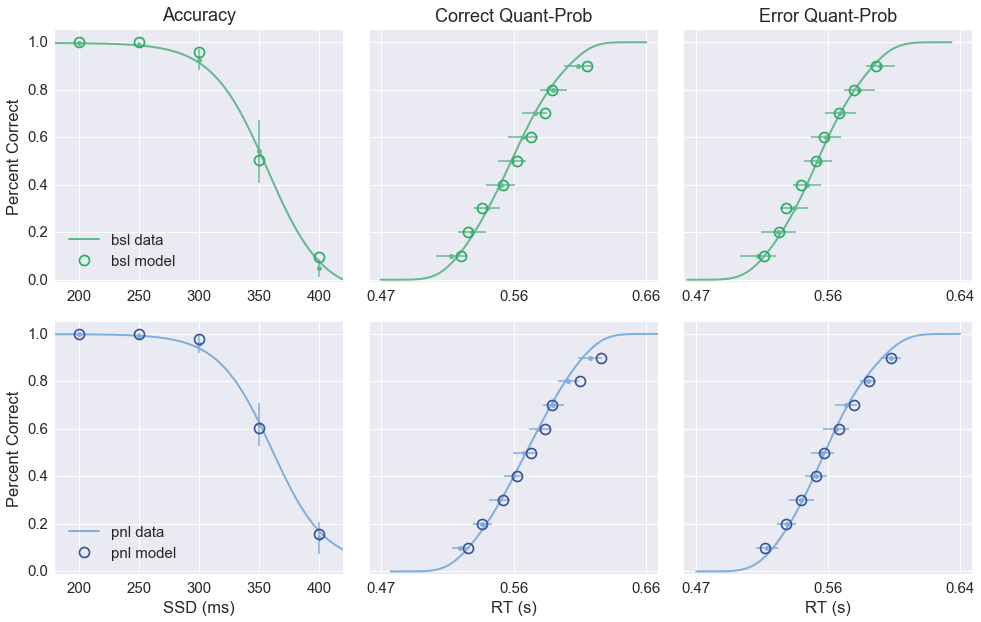

In [34]:
# because we've already the flat fits we can reinitialze a model with the optimized
# flat parameter estimates to bypass Step 1. go straight to the conditional fit
init_params = model.init_params
model = build.Model(data=data, kind='xdpm', depends_on={'v':'Cond'})
model.init_params = init_params
# now when we run optimize, the model will be initialized will the estimates 
# from Step 1. and will attempt to fit the 'bsl' and 'pnl' conditions with 
# all parameters fixed except for the drift-rate of the Go process.
model.optimize()

# Typically...
* ...you'll have specific hypotheses (H) about which parameters will depend on various task conditions so there's no reason to run step 1 and 2 separately. 
* In this case, simply initialize the model with the depends_on dictionary corresponding to your H...
    ``` python
    model = build.Model(kind='xdpm', depends_on={'v': 'Cond'})
    ```
...and hit the optimize button to fit the full model (Step 1 and 2)
    ``` py
    model.optimize(progress=True)
    ```

# Nested optimization of alternative models

* Nested optimization allows alternative models to be optimized using a single initial parameter set.

    ```python 
    m = build.Model(kind='xdpm', data=data, depends_on={'v': 'Cond'})
    nested_models = ['xb', 'a', 'tr']
    m.optimize_nested_models(models=nested_models)
    ```
* After fitting the model with **depends_on={'v': 'Cond'}**, **'v'** is replaced by the next parameter in the **nested_models** list **('xb' in this case)** and optimized using the same init params as the original model
* As a result, model selection is less likely to be biased by the initial parameter set
* Also, because Step 1 takes significantly longer than Step 2, nested optimization of multiple models is significantly faster than optimizing each model individually
* Run the cell below and go take a leisurely coffee break

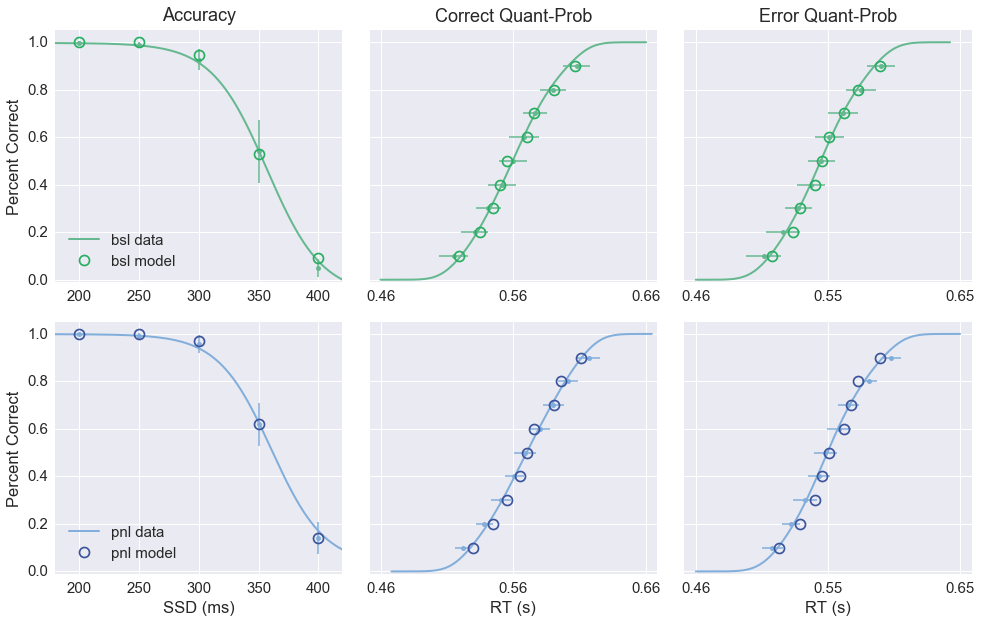

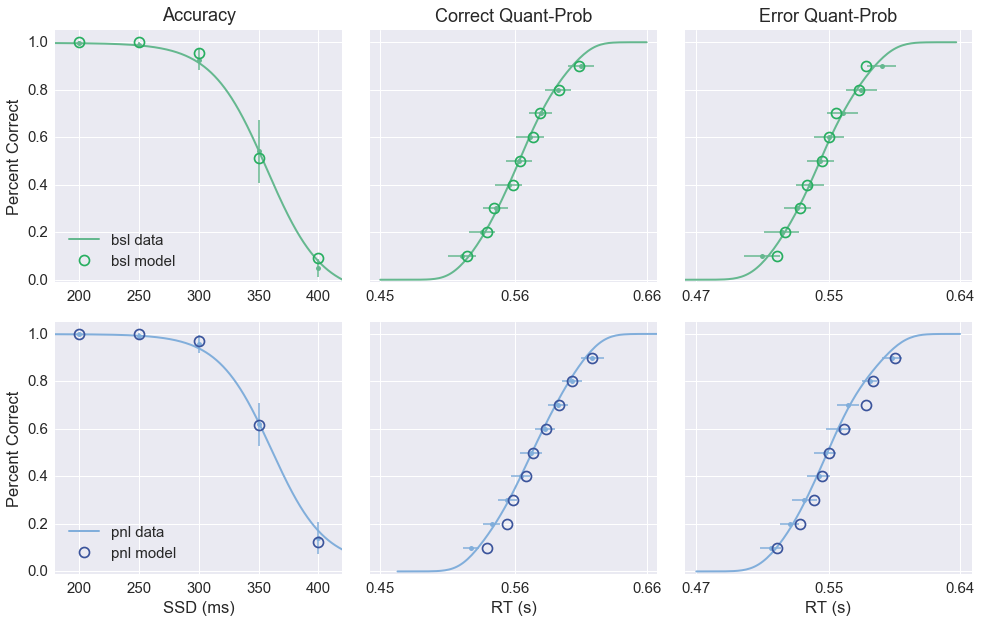

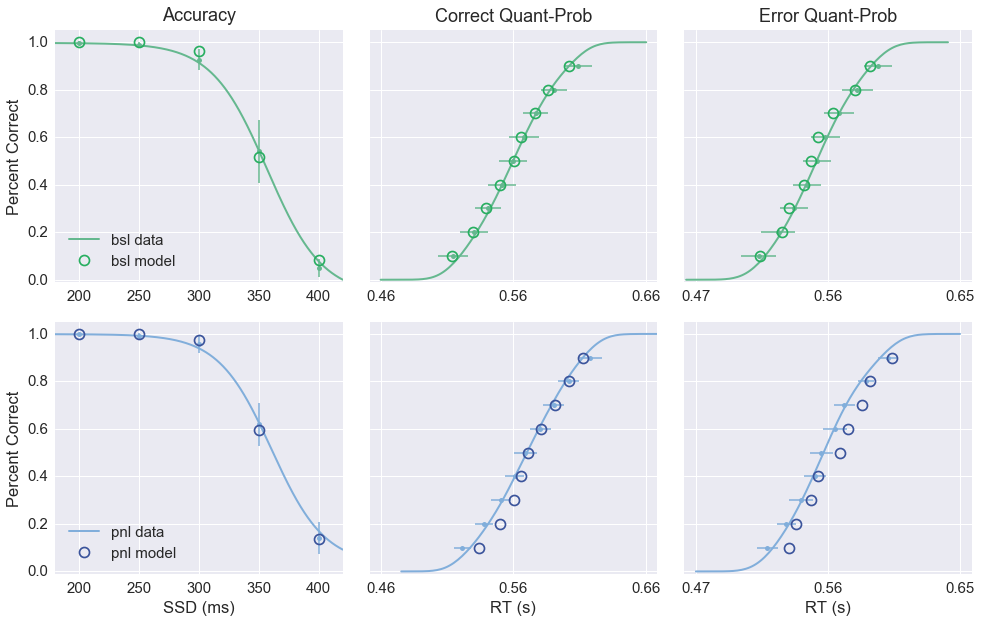

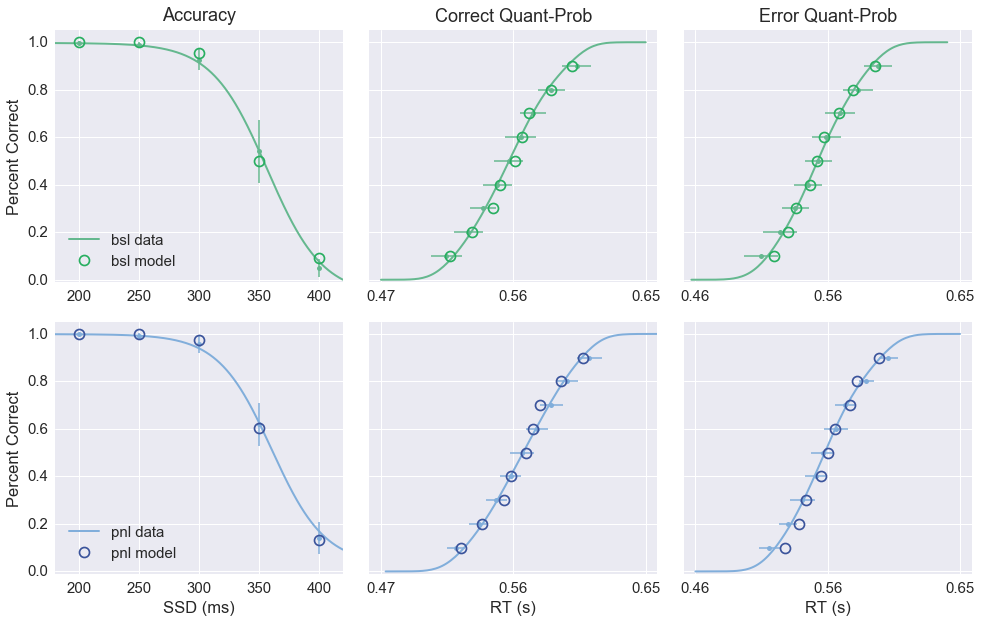

In [35]:
m = build.Model(kind='xdpm', data=data, depends_on={'v': 'Cond'})
nested_models = ['xb', 'a', 'tr']
m.optimize_nested_models(models=nested_models, plotfits=True, progress=True, saveplot=True)

# Model Comparison

v GOF:
AIC = -446.198699727
BIC = -445.634351535

xb GOF:
AIC = -429.946056644
BIC = -429.381708453

a GOF:
AIC = -425.359518909
BIC = -424.795170718

tr GOF:
AIC = -423.202349926
BIC = -422.638001734

AIC likes v model
BIC likes v model


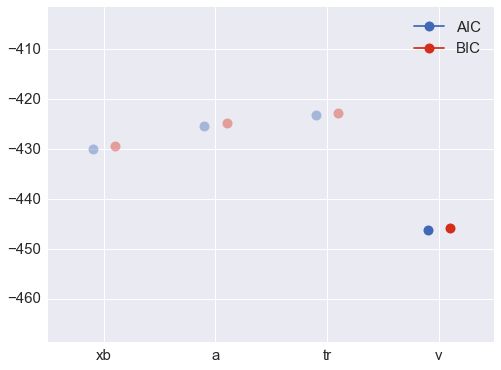

In [48]:
# Evaluate all nested fits and plot goodness-of-fit stats: AIC & BIC (Lower is better)
vis.compare_nested_models(m.fitDF, model_ids=['v', 'xb', 'a', 'tr'])

# Examine Best-Fit Model

In [37]:
# the fit summary (goodness of fit measures, etc.) 
m.fitDF

,idx,a,ssv,tr,xb,bsl,pnl,nfev,nvary,df,chi,rchi,logp,AIC,BIC,cnvrg
0,v,0.59935,-1.1055,0.13,2.176,0.93239,0.89708,211,2,46,0.0038855,8.4468e-05,-450.2,-446.2,-445.63,1
1,xb,0.59935,-1.1055,0.13,NaN,2.2012,2.057,1588,2,46,0.0054513,0.00011851,-433.95,-429.95,-429.38,0
2,a,NaN,-1.1055,0.13,2.176,0.5861,0.6241,214,2,46,0.0059979,0.00013039,-429.36,-425.36,-424.8,1
3,tr,0.59935,-1.1055,NaN,2.176,0.12853,0.13602,1467,2,46,0.0062736,0.00013638,-427.2,-423.2,-422.64,0
4,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# model predictions
# to save as csv file: model_v.yhatDF.to_csv("save_path", index=False)
# to extract values as numpy ndarray: model_v.yhatDF.loc[:, 'acc':].values
m.yhatDF.head()

,idx,Cond,acc,200,250,300,350,400,c10,c20,...,c90,e10,e20,e30,e40,e50,e60,e70,e80,e90
0,xdpm_v_average,bsl,0.99215,1.0,1.0000,0.9480,0.5290,0.0910,0.520,0.535,...,0.605,0.515,0.530,0.535,0.545,0.550,0.555,0.565,0.575,0.590
1,xdpm_v_average,pnl,0.98150,1.0,1.0000,0.9685,0.6205,0.1395,0.530,0.545,...,0.610,0.520,0.535,0.545,0.550,0.555,0.565,0.570,0.575,0.590
2,xdpm_xb_average,bsl,0.99315,1.0,1.0000,0.9535,0.5140,0.0925,0.520,0.535,...,0.605,0.520,0.525,0.535,0.540,0.550,0.555,0.560,0.575,0.580
3,xdpm_xb_average,pnl,0.98255,1.0,1.0000,0.9700,0.6145,0.1240,0.535,0.550,...,0.615,0.520,0.535,0.545,0.550,0.555,0.565,0.580,0.585,0.600
4,xdpm_a_average,bsl,0.99310,1.0,0.9995,0.9620,0.5175,0.0850,0.515,0.530,...,0.600,0.510,0.525,0.530,0.540,0.545,0.550,0.560,0.575,0.585


In [39]:
# best-fit parameter estimates also stored in popt dictionary
m.popt

{'a': 0.59934621014259859,
 'ssv': -1.1055156174854264,
 'tr': array([ 0.12853,  0.13602]),
 'tr_bsl': 0.12852780963458263,
 'tr_pnl': 0.13602379909048382,
 'v': 0.92423281913145783,
 'xb': 2.1759815023879234}

# Troubleshooting Ugly Fits

## Fit to individual subjects
```python
model = build.Model(data=data, fit_on='subjects')
```
## Other "kinds" of models...
* Currently only Dependent Process Model **(kind='dpm')** and Independent Race Model **(kind='irace')**
* Tell model to include a Dynamic Bias Signal **('xb')** by adding an **'x'** to the front of model **kind**
* To implement the **Dependent Process Model** with dynamic bias: 
    ```python
    model = build.Model(data=data, kind='xdpm')
    ```
* without: 
    ```python
    model = build.Model(data=data, kind='dpm')
    ```
* To implement the **Independent Race Model** with dynamic bias: 
    ```python
    model = build.Model(data=data, kind='xirace')
    ```
* without: 
    ```python
    model = build.Model(data=data, kind='irace')
    ```


## Other dependencies...
* Maybe subjects change their boundary height or go onset time across conditions
* Model with dynamic gain free across conditions:
```python
model = build.Model(data=data, depends_on={'xb':'Cond'})
```        

## Optimization parameters...
 * model.set_basinparams(nsuccess=50, tol=1e-30, ninits=10, nsamples=10000) 
 * model.set_fitparams(maxfev=5000, tol=1e-35)
 * Check out the wts vectors for extreme vals
     * Try re-running the fits with an unweighted model (all wts = 1) 
         * m = build.Model(data=data, ... weighted=False)
 * Error RTs can be particularly troublesome, sometimes un-shootably so...

In [6]:
import radd
radd.style_notebook()

Notebook Theme: Grade3
more at github.com/dunovank/jupyter-themes
